# Timing Comparison: Python `nested_ot` vs. `solve_dynamic`
This notebook runs both the Python `nested_ot` solver and the backward‐induction `solve_dynamic` solver on 10 runs with `grid_size = 0.2`, using the provided 4×4 matrices **L** and **M**, and reports both elapsed times and computed distances.

In [1]:
%load_ext autoreload
%autoreload 2
import sys

import matplotlib.pyplot as plt
sys.path.append('../')
random_seed = 5
import time
import numpy as np

from pnot.utils import *
from pnot import nested_ot
from aot_numerics.aot_measure_to_path import *
from aot_numerics.mainfunctions import *
from aot_numerics.FVI_bench import *
from aot_numerics.normal_ot import *


# Parameters
grid_size = 0.2
n_runs = 10
n_sample = 100

L = np.array([[1,0,0,0],[2,2,0,0],[1,1,3,0],[2,2,1,2]])
M = np.array([[1,0,0,0],[2,1,0,0],[3,2,1,0],[4,3,2,1]])

rng = np.random.default_rng(42)
power = 2


## Functions to get the fomrating in their code

In [3]:
# 1) Common quantize helper
def quantize_path(adapted, v2q):
    # adapted: shape (T+1, n_samples), v2q: real→code
    return np.array([[v2q[val] for val in path] for path in adapted.T], dtype=int)


# MARKOV

def build_measure_from_q(q):
    # q: (n, T+1) integer codes
    mu_x   = qpath2mu_x(q, markovian=True)
    c,nc,v,w,next_idx,nv_cum,q2idx = list_repr_mu_x(mu_x, markovian=True)

    root_codes, counts = np.unique(q[:,0], return_counts=True)
    root_w            = counts / counts.sum()

    def mu(node, x_parents):
        if node == 0:
            return [root_codes.reshape(-1,1), list(root_w)]
        idx  = node - 1
        cond = (int(x_parents[0]),)
        i    = c[idx].index(cond)
        codes   = np.array(v[idx][i], dtype=int).reshape(-1,1)
        weights = list(w[idx][i])
        return [codes, weights]

    def sup_mu(nodes):
        if not nodes:
            return np.empty((0,1),dtype=int)
        t = nodes[0]
        return np.unique(q[:,t]).reshape(-1,1)

    return mu, sup_mu
# --- build the Markov chain graph ---
T = L.shape[0]
g_markov = Graph(T+1)
for t in range(T):
    g_markov.addEdge(t, t+1)

## NON_MARKOV


# 2) Build measure for full-history
def build_measure_full(q):
    """
    q: np.ndarray shape (n_samples, T+1) of integer codes
    returns: mu(node, x_parents), sup_mu(nodes)
    """
    # build all prefix→next transitions
    mu_x = qpath2mu_x(q, markovian=False)
    c,nc,v,w,next_idx,nv_cum,q2idx = list_repr_mu_x(mu_x, markovian=False)

    # marginal at node 0
    root_codes, counts = np.unique(q[:,0], return_counts=True)
    root_w = counts / counts.sum()

    def mu(node, x_parents):
        if node == 0:
            return [root_codes.reshape(-1,1), list(root_w)]
        idx  = node - 1            # transitions X_{node} | X_{0:(node-1)}
        cond = tuple(int(x) for x in x_parents)
        i    = c[idx].index(cond)  # find the right conditional block
        codes   = np.array(v[idx][i], dtype=int).reshape(-1,1)
        weights = list(w[idx][i])
        return [codes, weights]

    def sup_mu(nodes):
        # return all unique joint codes over the given set of nodes
        if not nodes:
            return np.empty((0, len(nodes)), dtype=int)
        cols = list(nodes)
        arr  = q[:, cols]                       # shape (n_samples, len(nodes))
        uniq = np.unique(arr, axis=0)           # deduplicate rows
        return uniq                             # shape (#unique, len(nodes))

    return mu, sup_mu

# 3) Build the full-history DAG on T+1 nodes
T = L.shape[0]
g_full = Graph(T+1)
for i in range(T+1):
    for j in range(i+1, T+1):
        g_full.addEdge(i, j)


n_sample =  100
run =  0
run =  1
run =  2
run =  3
run =  4
n_sample =  200
run =  0
run =  1
run =  2
run =  3
run =  4
n_sample =  300
run =  0
run =  1
run =  2
run =  3
run =  4
n_sample =  500
run =  0
run =  1
run =  2
run =  3
run =  4
n_sample =  1000
run =  0
run =  1
run =  2
run =  3
run =  4


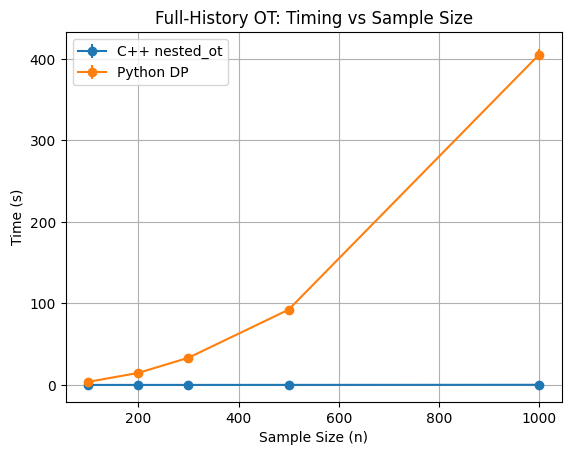

 n   |  C++ (mean ± std)   |  PyDP (mean ± std)   |  Speed-up (× faster in C++)
-----+---------------------+----------------------+----------------------------
 100 |   0.004 ± 0.000   |   3.753 ± 0.124    |  1067.7×
 200 |   0.011 ± 0.000   |  14.746 ± 0.397    |  1394.4×
 300 |   0.019 ± 0.001   |  33.338 ± 0.782    |  1737.3×
 500 |   0.045 ± 0.004   |  92.299 ± 1.687    |  2070.6×
1000 |   0.165 ± 0.002   |  405.226 ± 6.960    |  2460.7×


In [6]:
# Parameters
grid_size   = 0.2
power       = 2
num_threads = 250
n_runs      = 5
sample_sizes= [100, 200, 300, 500, 1000]

# Build full‐history graph on T+1 nodes
T = 4
g_full = Graph(T+1)
for i in range(T+1):
    for j in range(i+1, T+1):
        g_full.addEdge(i, j)

rng = np.random.default_rng(42)

# Storage
means_cpp = []
std_cpp   = []
means_py  = []
std_py    = []

for n_sample in sample_sizes:
    print("n_sample = ", n_sample)
    run_cpp = []
    run_py  = []
    for run in range(n_runs):
        print("run = ", run)
        seed1 = int(rng.integers(0,10000))
        X, _  = matrixL2paths(L, n_sample, seed=seed1)
        Y, _  = matrixL2paths(M, n_sample, seed=seed1)

        # C++ solver
        t0 = time.perf_counter()
        _  = nested_ot(X, Y,
                       grid_size=grid_size,
                       markovian=False,
                       num_threads=num_threads,
                       power=power)
        run_cpp.append(time.perf_counter()-t0)

        # Python DP
        X_ad = path2adaptedpath(X, grid_size)
        Y_ad = path2adaptedpath(Y, grid_size)
        all_vals = np.unique(np.concatenate([X_ad.ravel(), Y_ad.ravel()]))
        v2q = {v:i for i,v in enumerate(all_vals)}
        q2v = all_vals
        qX  = quantize_path(X_ad, v2q)
        qY  = quantize_path(Y_ad, v2q)
        mu, sup_mu = build_measure_full(qX)
        nu, sup_nu = build_measure_full(qY)

        cost = []
        for t in range(T+1):
            cost.append((
                [t],
                lambda x,y,p=power,q2v=q2v:
                  abs(q2v[int(x[0])] - q2v[int(y[0])])**p
            ))

        t1 = time.perf_counter()
        _ , _ = solve_dynamic(cost, mu, nu, sup_mu, sup_nu,
                              g_full, method='pot', outputflag=0)
        run_py.append(time.perf_counter()-t1)

    means_cpp.append(np.mean(run_cpp))
    std_cpp.append( np.std(run_cpp))
    means_py.append( np.mean(run_py))
    std_py.append(  np.std(run_py))

# Plot
plt.errorbar(sample_sizes, means_cpp, yerr=std_cpp, label='C++ nested_ot', marker='o')
plt.errorbar(sample_sizes, means_py,  yerr=std_py,  label='Python DP',       marker='o')
plt.xlabel('Sample Size (n)')
plt.ylabel('Time (s)')
plt.title('Full‐History OT: Timing vs Sample Size')
plt.legend(); plt.grid(True)
plt.show()

# Summary table with speed-up factor
print(" n   |  C++ (mean ± std)   |  PyDP (mean ± std)   |  Speed-up (× faster in C++)")
print("-----+---------------------+----------------------+----------------------------")
for n, mc, sc, mp, sp in zip(sample_sizes, means_cpp, std_cpp, means_py, std_py):
    speedup = mp/mc
    print(f"{n:4d} |  {mc:6.3f} ± {sc:.3f}   |  {mp:6.3f} ± {sp:.3f}    |  {speedup:6.1f}×")

In [3]:
import time

times_nested  = []
times_dynamic = []
dist_nested   = []
dist_dynamic  = []

for run in range(n_runs):
    seed1 = int(rng.integers(0,10000))
    X, _ = matrixL2paths(L, n_sample, seed=seed1)
    Y, _ = matrixL2paths(M, n_sample, seed=seed1)

    # 1) nested_ot (uses its own internal quantization)
    t0 = time.perf_counter()
    dn = nested_ot(X, Y, grid_size=grid_size, markovian=True,
                   num_threads=4, power=power)
    tn = time.perf_counter() - t0

    # 2) build a **common** grid from both adapted paths
    X_ad = path2adaptedpath(X, grid_size)
    Y_ad = path2adaptedpath(Y, grid_size)
    all_vals = np.unique(np.concatenate([X_ad.flatten(), Y_ad.flatten()]))
    v2q      = {v: i for i, v in enumerate(all_vals)}
    q2v      = all_vals  # code → real

    # 3) quantize both with the same mapping
    qX = quantize_path(X_ad, v2q)
    qY = quantize_path(Y_ad, v2q)

    # 4) build measures on codes
    mu,  sup_mu  = build_measure_from_q(qX)
    nu,  sup_nu  = build_measure_from_q(qY)

    # 5) cost lambdas that map codes back to real via q2v
    cost = []
    for t in range(T+1):
        cost.append((
          [t],
          lambda x, y, p=power, q2v=q2v:
            abs(q2v[int(x[0])] - q2v[int(y[0])])**p
        ))

    # 6) run solve_dynamic
    t1 = time.perf_counter()
    od, _ = solve_dynamic(cost, mu, nu, sup_mu, sup_nu, g,
                          method='pot', outputflag=0)
    td = time.perf_counter() - t1

    times_nested .append(tn)
    dist_nested  .append(dn)
    times_dynamic.append(td)
    dist_dynamic .append(od[-1])

    print(f"Run {run+1:2d}:  nested={dn:8.4f} ({tn:.3f}s),  "
          f"dynamic={od[-1]:8.4f} ({td:.3f}s)")

# Check final agreement
print("\nΔ between nested and dynamic per run:")
for i,(d1,d2) in enumerate(zip(dist_nested,dist_dynamic),1):
    print(f" run {i:2d}: Δ = {abs(d1-d2):.2e}")

Run  1:  nested= 27.2827 (0.007s),  dynamic= 27.2827 (1.786s)
Run  2:  nested= 23.5357 (0.003s),  dynamic= 23.5357 (1.436s)
Run  3:  nested= 29.2415 (0.002s),  dynamic= 29.2415 (1.378s)
Run  4:  nested= 30.2981 (0.002s),  dynamic= 30.2981 (1.355s)
Run  5:  nested= 27.9218 (0.002s),  dynamic= 27.9218 (2.157s)
Run  6:  nested= 28.4133 (0.003s),  dynamic= 28.4133 (1.445s)
Run  7:  nested= 28.8463 (0.002s),  dynamic= 28.8463 (1.403s)
Run  8:  nested= 27.5873 (0.002s),  dynamic= 27.5873 (1.337s)
Run  9:  nested= 28.0739 (0.002s),  dynamic= 28.0739 (1.332s)
Run 10:  nested= 32.1519 (0.002s),  dynamic= 32.1519 (1.422s)

Δ between nested and dynamic per run:
 run  1: Δ = 0.00e+00
 run  2: Δ = 0.00e+00
 run  3: Δ = 3.55e-15
 run  4: Δ = 7.11e-15
 run  5: Δ = 0.00e+00
 run  6: Δ = 3.55e-15
 run  7: Δ = 3.55e-15
 run  8: Δ = 3.55e-15
 run  9: Δ = 0.00e+00
 run 10: Δ = 7.11e-15


In [4]:
import time
# 1) Common quantize helper
def quantize_path(adapted, v2q):
    # adapted: shape (T+1, n_samples), v2q: real→code
    return np.array([[v2q[val] for val in path] for path in adapted.T], dtype=int)

# 2) Build measure for full-history
def build_measure_full(q):
    """
    q: np.ndarray shape (n_samples, T+1) of integer codes
    returns: mu(node, x_parents), sup_mu(nodes)
    """
    # build all prefix→next transitions
    mu_x = qpath2mu_x(q, markovian=False)
    c,nc,v,w,next_idx,nv_cum,q2idx = list_repr_mu_x(mu_x, markovian=False)

    # marginal at node 0
    root_codes, counts = np.unique(q[:,0], return_counts=True)
    root_w = counts / counts.sum()

    def mu(node, x_parents):
        if node == 0:
            return [root_codes.reshape(-1,1), list(root_w)]
        idx  = node - 1            # transitions X_{node} | X_{0:(node-1)}
        cond = tuple(int(x) for x in x_parents)
        i    = c[idx].index(cond)  # find the right conditional block
        codes   = np.array(v[idx][i], dtype=int).reshape(-1,1)
        weights = list(w[idx][i])
        return [codes, weights]

    def sup_mu(nodes):
        # return all unique joint codes over the given set of nodes
        if not nodes:
            return np.empty((0, len(nodes)), dtype=int)
        cols = list(nodes)
        arr  = q[:, cols]                       # shape (n_samples, len(nodes))
        uniq = np.unique(arr, axis=0)           # deduplicate rows
        return uniq                             # shape (#unique, len(nodes))

    return mu, sup_mu

# 3) Build the full-history DAG on T+1 nodes
T = L.shape[0]
g_full = Graph(T+1)
for i in range(T+1):
    for j in range(i+1, T+1):
        g_full.addEdge(i, j)

# 4) Compare on n_runs
times_nested   = []
times_dynamic  = []
dist_nested    = []
dist_dynamic   = []

for run in range(n_runs):
    seed1 = int(rng.integers(0,10000))
    X, _ = matrixL2paths(L, n_sample, seed=seed1)
    Y, _ = matrixL2paths(M, n_sample, seed=seed1)

    # a) nested_ot (full-history flag)
    t0 = time.perf_counter()
    dn = nested_ot(
        X, Y,
        grid_size=grid_size,
        markovian=False,    # full history
        num_threads=4,
        power=power
    )
    tn = time.perf_counter() - t0

    # b) build one common real→code mapping on the union of X,Y
    X_ad = path2adaptedpath(X, grid_size)
    Y_ad = path2adaptedpath(Y, grid_size)
    all_vals = np.unique(np.concatenate([X_ad.ravel(), Y_ad.ravel()]))
    v2q      = {v:i for i,v in enumerate(all_vals)}
    q2v      = all_vals

    # quantize both paths with the same codebook
    qX = quantize_path(X_ad, v2q)
    qY = quantize_path(Y_ad, v2q)

    # c) build DP measures on codes
    mu,  sup_mu  = build_measure_full(qX)
    nu,  sup_nu  = build_measure_full(qY)

    # d) cost functions in real units via q2v
    cost = []
    for t in range(T+1):
        cost.append((
            [t],
            lambda x, y, p=power, q2v=q2v:
                abs(q2v[int(x[0])] - q2v[int(y[0])])**p
        ))

    # e) solve_dynamic with full-history graph
    t1 = time.perf_counter()
    od, _ = solve_dynamic(
        cost, mu, nu, sup_mu, sup_nu,
        g_full,
        method='pot',
        outputflag=0
    )
    td = time.perf_counter() - t1

    times_nested .append(tn)
    dist_nested  .append(dn)
    times_dynamic.append(td)
    dist_dynamic .append(od[-1])

    print(f"Run {run+1:2d}:  "
          f"nested={dn:.6f} ({tn:.3f}s),  "
          f"dynamic={od[-1]:.6f} ({td:.3f}s)")

# final check
print("\nMax |Δ| =", np.max(np.abs(np.array(dist_nested)-np.array(dist_dynamic))))

Run  1:  nested=17.217600 (0.004s),  dynamic=17.217600 (4.067s)
Run  2:  nested=13.740533 (0.003s),  dynamic=13.740533 (3.285s)
Run  3:  nested=18.618600 (0.003s),  dynamic=18.618600 (3.086s)
Run  4:  nested=16.483200 (0.003s),  dynamic=16.483200 (3.087s)
Run  5:  nested=19.067200 (0.003s),  dynamic=19.067200 (3.145s)
Run  6:  nested=16.585600 (0.003s),  dynamic=16.585600 (3.093s)
Run  7:  nested=17.256876 (0.003s),  dynamic=17.256876 (3.132s)
Run  8:  nested=17.050933 (0.003s),  dynamic=17.050933 (3.047s)
Run  9:  nested=18.062600 (0.003s),  dynamic=18.062600 (3.124s)
Run 10:  nested=15.455207 (0.003s),  dynamic=15.455207 (3.089s)

Max |Δ| = 1.0658141036401503e-14


In [7]:
print(times_cpp)
print(times_py)

[[0.003626603865996003, 0.003133449936285615, 0.0029899408109486103, 0.003000900847837329, 0.003046757075935602, 0.003064469899982214, 0.003140903078019619, 0.0030330009758472443, 0.002992035122588277, 0.002902036067098379], [0.04388221795670688, 0.04523422499187291, 0.04660440608859062, 0.046734842006117105, 0.04658832307904959, 0.04606294399127364, 0.0456738299690187, 0.05650763912126422, 0.05480770114809275, 0.05609256215393543]]
[[3.0123146059922874, 3.2704001639503986, 3.1278282459825277, 3.190059026936069, 3.09913676395081, 3.1729163080453873, 3.2239908531773835, 3.19708616216667, 3.15303117595613, 3.1279659010469913], [75.04367926693521, 75.38354430301115, 76.38452928210609, 76.32768383901566, 76.62287387717515, 76.68618604703806, 69.60337215987965, 71.55458113201894, 67.70026218192652, 70.11626538587734]]
